# Replication code

## PPOL 5202, Final Project

### Kumar H (hk939)

---

In [1]:
import googlemaps
import pandas as pd
import numpy as np
from shapely import wkt
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from shapely.geometry import Point
from shapely.wkt import loads
from shapely import affinity, Point
import os



from fuzzywuzzy import fuzz
from joblib import Parallel, delayed
from tqdm import tqdm


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


C:\ProgramData\Anaconda3\envs\g_env\lib\site-packages\pyproj\__init__.py:91: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


### Set directory, Load solar panel data

In [3]:
os.chdir(r'raw_data')


## installed solar panels
solar = pd.read_csv('dc_generators_geo.csv')


# Remove parentheses and split by comma
solar['geocoded2'] = solar['geocoded'].str.replace('[()]', '', regex=True).str.split(',')


# Convert to tuple of floats
solar['geocoded2'] = solar['geocoded2'].apply(lambda x: (float(x[0]), float(x[1])) if x is not None else None)

# Create Point
solar['geom_point'] = solar['geocoded2'].apply(lambda coords: Point(coords[1], coords[0]) if coords is not None else None)

solar = gpd.GeoDataFrame(solar, geometry='geom_point',  crs='epsg:4326')


## merge building polygons


In [4]:
build_shp = gpd.read_file('Building_Footprints.zip')

build_shp['geom_build']=build_shp['geometry']

#spatial join with above CAMA-solar df
solar_build = solar.sjoin(build_shp, predicate='intersects', how='left')
solar_build = gpd.GeoDataFrame(solar_build, geometry='geom_build', crs='epsg:4326')

# Step 1: Find the geom_build value for the specified Number
replacement_geom = solar_build.loc[solar_build['Number'] == 'DC-09125-SUN-I', 'geom_build'].iloc[0]
# replace buildings not found with this arbitrary building shape

# Step 2: Replace missing values in geom_build with this value
solar_build['geom_build'] = solar_build['geom_build'].fillna(replacement_geom)

#store as wkt
solar_build['geom_build'] = solar_build['geom_build'].apply(lambda x: x.wkt)
solar_build['geom_point'] = solar_build['geom_point'].apply(lambda x: x.wkt)

solar_build=solar_build[['Facility Address', 'Unit ID', 'Number',
       'Date Approved', 'Energy Facility', 'Fuel Type', 'Capacity (MW)', 'geom_build', 'geom_point']]

#export

solar_build.shape
solar_build['Capacity (MW)'].sum()


C:\ProgramData\Anaconda3\envs\g_env\lib\site-packages\geopandas\geoseries.py:624: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
C:\ProgramData\Anaconda3\envs\g_env\lib\site-packages\geopandas\geodataframe.py:1350: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")
C:\ProgramData\Anaconda3\envs\g_env\lib\site-packages\geopandas\geoseries.py:624: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


(12721, 9)

201.46033214000005

<Axes: >

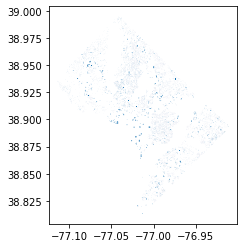

In [5]:


solar_build['geom_build'] = solar_build['geom_build'].apply(wkt.loads)

solar_build = gpd.GeoDataFrame(solar_build, geometry='geom_build', crs='epsg:4326')



solar_build.plot()



solar_build.to_csv('solar_building.csv')

## Property tax data - CAMA 


residential - https://opendata.dc.gov/datasets/DCGIS::computer-assisted-mass-appraisal-residential/about

Commercial - 

Condo - 

### Concatenate tables


Generate a variable `cama_source` to record which table it came from

In [6]:
cama_res = pd.read_csv('Computer_Assisted_Mass_Appraisal_-_Residential.csv')
cama_res['cama_source'] = 'residential'

cama_com =  pd.read_csv('Computer_Assisted_Mass_Appraisal_-_Commercial.csv')
cama_com['cama_source'] = 'commercial'

cama_con =  pd.read_csv('Computer_Assisted_Mass_Appraisal_-_Condominium.csv')
cama_con['cama_source'] = 'condominium'

cama = pd.concat([cama_res, cama_con, cama_com])

## SSL, addresses and coordinates

### TODO- Visualize the many-to-many relations
The relationship between a property and an address is **many-to-many**. In DC a SSL (Square, Suffix, Lot) is used to identify a property. 

- One SSL can have multiple addresses located on it. This often includes garden-style apartment complexes as well as corner buildings with separate addresses facing each adjacent street.

- One address can also sit upon multiple SSLs. One single family residence can sit upon multiple lots. 

The cross reference table contains the many-to-many relationship between address IDs and SSLs. [A small percentage of addresses do not have an associated SSL (such as metro entrances or many addresses on Federal property.] Use this cross reference table to relate the District's address points in the Master Address Repository (MAR) with the SSLs and vice versa.

### 1. Address SSL 

Thre are total 203872 unique SSLs in the reference.
There are unique 14372d MAR_IDs in Address reference SSL reference.

https://opendata.dc.gov/datasets/DCGIS::address-and-square-suffix-lot-cross-reference/about

### 2. Address points
Thre are total 125087 unique SSLs.
There are unique 144108 MAR_IDs.

The dataset contains locations and attributes of Address points, created as part of the Master Address Repository (MAR) 

https://opendata.dc.gov/datasets/DCGIS::address-points/about



### Merge 1: Address-SSL reference (on MAR_ID)

In [7]:
address_ssl =  pd.read_csv('Address_and_Square_Suffix_Lot_Cross_Reference.csv')

address_pts = pd.read_csv('Address_Points.csv')

address_ref = pd.merge(address_pts, address_ssl, left_on='MAR_ID', right_on='MARID', how='inner')


C:\Users\HK\AppData\Local\Temp\ipykernel_19196\2508224190.py:3: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  address_pts = pd.read_csv('Address_Points.csv')


### Merge 2: CAMA-Address reference (on SSL)

In [8]:
cama = pd.merge(cama, address_ref, left_on='SSL', right_on='SSL_x', how='left')


### Merge 3: CAMA - Solar (on address)

### First, replace naming conventions in solar (Street --> St)

In [9]:
solar_build['Address_merge'] = solar_build['Facility Address'].str.split(",").str[0].str.lower()


cama['ADDRESS_merge'] = cama['ADDRESS'].str.split(",").str[0].str.lower()

# mapping - the 2nd last elent - lane, road, ave etc.
# cama['2nd_suffix'] = cama['ADDRESS_merge'].str.split(' ').str[-2]
# solar['2nd_suffix'] = solar['Address_merge'].str.split(' ').str[-2]

# Drop NA entries in address
cama = cama.dropna(subset= 'ADDRESS_merge')


mapping = {
    'st': 'street',
    'ct': 'court',
    'ave': 'avenue',
    'pl': 'place',
    'cir': 'circle',
    'ln': 'lane',
    'way': 'way',
    'aly': 'alley',
    'sq': 'square',
    'terr': 'terrace',
    'rd': 'road',
    'pkwy': 'parkway',
    'dr': 'drive',
    'blvd': 'boulevard',
    'crescent': 'crescent'
}


def replace_street_abbreviation(address):
    try:
        parts = address.split()
        # Check if the item at index -2 exists in the mapping
        if parts[-2] in mapping:
            parts[-2] = mapping[parts[-2]]
        return ' '.join(parts)
    except:
        return ''
    
# Apply the function to the solar dataset
solar_build['clean_address_solar'] = [replace_street_abbreviation(address) for address in solar_build['Address_merge']]
solar_build['solar_adopted'] = 1

#de-duplicate
cama_dedup = cama[cama.duplicated('ADDRESS_merge', keep=False)]

#merge
solar_cama_build = pd.merge(left=cama_dedup , right=solar_build , left_on=['ADDRESS_merge'] , 
                       right_on=['clean_address_solar'] , how='inner')

# # Find unmerged records
# unmerged_cama = cama_dedup[~cama_dedup['ADDRESS_merge'].isin(solar_cama_build['ADDRESS_merge'])]
# unmerged_solar = solar_build[~solar_build['clean_address_solar'].isin(solar_cama_build['clean_address_solar'])]

# # Convert unmerged_solar to a GeoDataFrame
# unmerged_solar['geom_build'] = unmerged_solar['geom_build'].apply(wkt.loads)

# unmerged_solar_geo = gpd.GeoDataFrame(unmerged_solar, geometry='geom_build', crs='epsg:4326')
# unmerged_cama = gpd.GeoDataFrame(unmerged_cama, geometry=gpd.points_from_xy(unmerged_cama['LONGITUDE'],
#                                                                             unmerged_cama['LATITUDE']), crs='epsg:4326')

# # Perform the spatial join
# solar_cama_spatial_joined = gpd.sjoin(unmerged_cama, unmerged_solar_geo, how="inner", op='intersects')

# final_joined_data = pd.concat([solar_cama_build, solar_cama_spatial_joined], ignore_index=True).drop_duplicates(subset='Number')


#drop duplicates
solar_cama_build.shape
solar_cama_build['Capacity (MW)'].sum()

(4582, 126)

191.6080596

In [10]:

solar_cama_build = solar_cama_build[['BATHRM',
 'HF_BATHRM',
 'HEAT_D',
 'AC',
 'NUM_UNITS',
 'ROOMS',
 'BEDRM',
 'AYB',
 'YR_RMDL',
 'EYB',
 'STORIES',
 'PRICE',
 'QUALIFIED',
 'SALE_NUM',
 'GBA',
 'BLDG_NUM',
 'STYLE_D',
 'STRUCT_D',
 'GRADE_D',
 'CNDTN_D',
 'EXTWALL_D',
 'ROOF_D',
 'INTWALL_D',
'RESIDENTIAL_TYPE',
 'KITCHENS',
 'FIREPLACES',
 'USECODE',
 'LANDAREA',
 'cama_source',
 'CMPLX_NUM',
 'LIVING_GBA',
 'SECT_NUM',
 'STRUCT_CL_D',
 'WALL_HGT',

 'Unit ID',
 'Number',
 'Date Approved',
 'Energy Facility',
 'Fuel Type',
 'Capacity (MW)',
  'WARD',                      
 'ZIPCODE',
'clean_address_solar', 'geom_point', 'geom_build',
 'solar_adopted', 'LATITUDE',
 'LONGITUDE']]

#fill missing solar adopted with 0
# solar_cama_build.solar_adopted = solar_cama_build.solar_adopted.fillna(0)

solar_cama_build.to_csv('solar_cama_building.csv')

<Axes: >

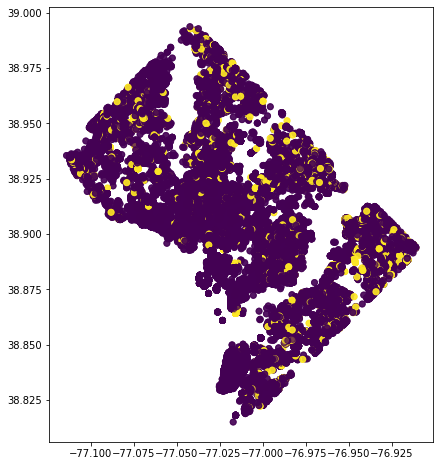

In [77]:

# 
#convert to geodataframe
gdf = gpd.GeoDataFrame(joined_cama, geometry=gpd.points_from_xy(joined_cama.LONGITUDE, joined_cama.LATITUDE),crs='epsg:4326')
fig, ax = plt.subplots(figsize=(8,8))
gdf.plot(ax=ax, column='solar_adopted', alpha=.7)


# export

# # gdf['geocode'] = gdf['geocoded2'].apply(lambda x: x.wkt)
# gdf.to_csv('all_pt.csv', index=False)

## Merge Zip and Ward shapefile

In [178]:
# all buildings
solar_cama_build_all = pd.merge(left=cama_dedup , right=solar_build , left_on=['ADDRESS_merge'] , 
                       right_on=['clean_address_solar'] , how='left')
solar_cama_build_all.solar_adopted=solar_cama_build_all.solar_adopted.fillna(0, inplace=True)
solar_cama_build_all['n']=1

In [51]:
ward = gpd.read_file('Wards_dec8.geojson', crs='epsg:4326')

ward['geom_ward'] = ward['geometry']
ward_shp = ward[['NAME','geom_ward' ]]

ward_solar = ward.sjoin(solar, predicate='intersects', how='left')

# cama = gpd.GeoDataFrame(cama, geometry=gpd.points_from_xy(cama['LONGITUDE'],
#                                                                             cama['LATITUDE']), crs='epsg:4326')
# Group by Ward and calculate aggregated statistics
ward_solar = ward_solar.groupby('NAME').agg(
    total_capacity_mw=('Capacity (MW)', 'sum'),
    avg_capacity_mw=('Capacity (MW)', 'mean'),
    solar_adopted_count=('Facility Address', 'nunique'),
)
cama_ward = cama.groupby('WARD').agg(
    tot_buildings=('ADDRESS_ID', 'nunique')).reset_index()

#MERGE cama
ward_solar = ward_solar.merge(cama_ward, left_on='NAME', right_on='WARD', how='left')

# Calculate the percentage of solar adoption
ward_solar['perc_solar'] = ward_solar['solar_adopted_count'] / ward_solar['tot_buildings']

#merge shapes again
ward_solar = ward_solar.merge(ward_shp, left_on='WARD', right_on='NAME', how='inner')

ward_solar['geom_ward'] = ward_solar['geom_ward'].apply(lambda x: x.wkt)
ward_solar.to_csv('ward_solar.csv', index=False)


ward_solar.shape
ward_solar.total_capacity_mw.sum()

(8, 8)

201.46033214000002

In [128]:
zipcode = gpd.read_file('Zip_Codes_dec8.geojson', crs='epsg:4326')


#drop duplicate zips
# List of GLOBALID values to drop
global_ids_to_drop = [
    "{E7C1154B-0B74-4E98-BE24-B7A845D8BF06}",
    "{96F87B83-7288-4D91-9B7E-109DE5DABCEF}",
    "{5D2F5774-132B-4FAA-B05C-EDD97B608BC7}",
    "{1A967DF6-BE3B-4DB4-AEF9-592367EB7966}"
]

# Drop rows with specified GLOBALIDs
zipcode = zipcode[~zipcode.GLOBALID.isin(global_ids_to_drop)]

zipcode['geom_zipcode'] = zipcode['geometry']

zipcode_shp = zipcode[['ZIPCODE', 'NAME', 'geom_zipcode']]

# Spatial join with solar data
zipcode_solar = zipcode.sjoin(solar, predicate='intersects', how='left')


# Group by Zipcode and calculate aggregated statistics
zipcode_solar = zipcode_solar.groupby('ZIPCODE').agg(
    total_capacity_mw=('Capacity (MW)', 'sum'),
    avg_capacity_mw=('Capacity (MW)', 'mean'),
    solar_adopted_count=('Facility Address', 'nunique'),
)

cama_zipcode = cama.groupby('ZIPCODE').agg(
    tot_buildings=('ADDRESS_ID', 'nunique')).reset_index()

# Merge with CAMA data
zipcode_solar = zipcode_solar.merge(cama_zipcode, left_on='ZIPCODE', right_on='ZIPCODE', how='left')
# Calculate the percentage of solar adoption
zipcode_solar['perc_solar'] = zipcode_solar['solar_adopted_count'] / zipcode_solar['tot_buildings']


# Merge shapes again
zipcode_solar = zipcode_solar.merge(zipcode_shp, left_on='ZIPCODE', right_on='ZIPCODE', how='inner')


# Convert geometry to Well-Known Text (WKT) format
zipcode_solar['geom_zipcode'] = zipcode_solar['geom_zipcode'].apply(lambda x: x.wkt)

#fill NA values
zipcode_solar[['total_capacity_mw', 'avg_capacity_mw', 'solar_adopted_count', 'tot_buildings', 'perc_solar']] = \
    zipcode_solar[['total_capacity_mw', 'avg_capacity_mw', 'solar_adopted_count', 'tot_buildings', 'perc_solar']].fillna(0)


# Checking the shape and total capacity
zipcode_solar['NAME'] = np.where(zipcode_solar['NAME']==' ', zipcode_solar['ZIPCODE'], zipcode_solar['NAME'])

# Save to CSV
zipcode_solar.to_csv('zipcode_solar.csv', index=False)

print(zipcode_solar.total_capacity_mw.sum())


,ZIPCODE,total_capacity_mw,avg_capacity_mw,solar_adopted_count,tot_buildings,perc_solar,NAME,geom_zipcode
0,20001,6.394968,0.011976,531,6985.0,0.076020,20001,POLYGON ((-77.01796555190536 38.92897151066582...
1,20002,16.794930,0.010329,1622,15274.0,0.106194,20002,"POLYGON ((-77.0028600551919 38.92560277396964,..."
2,20003,8.803687,0.010119,867,7655.0,0.113259,20003,MULTIPOLYGON (((-76.96946878259806 38.89012196...
3,20004,0.763100,0.190775,4,189.0,0.021164,20004,POLYGON ((-77.01990819173145 38.89868013741697...
4,20005,0.649050,0.029502,22,677.0,0.032496,20005,POLYGON ((-77.03159732091102 38.91100938304576...
...,...,...,...,...,...,...,...,...
163,20590,0.000000,0.000000,0,1.0,0.000000,US DEPARTMENT OF TRANSPORTATION,POLYGON ((-77.00218113381474 38.87546155895062...
164,20591,0.000000,0.000000,0,1.0,0.000000,FEDERAL AVIATION ADMINISTRATION,POLYGON ((-77.02323065198773 38.88757652575877...
165,20593,0.000000,0.000000,0,2.0,0.000000,20593,POLYGON ((-77.00049452341217 38.85161182070028...
166,20594,0.000000,0.000000,0,0.0,0.000000,FEDERAL AVIATION ADMINISTRATION,POLYGON ((-77.02312281810201 38.88680999699158...


201.46033214


### THrough time

#### Ward

In [35]:
ward = gpd.read_file('Wards_dec8.geojson', crs='epsg:4326')

ward_solar = ward.sjoin(solar, predicate='intersects', how='left')

# Convert 'Date Approved' to month-year format
ward_solar['month'] = pd.to_datetime(ward_solar['Date Approved'], format='%d-%m-%Y').dt.strftime('%Y')

# Assuming 'DATE_APPROVED' is a column in your 'ward_solar' DataFrame
# Group by both Ward ('NAME') and 'DATE_APPROVED', then calculate aggregated statistics
ward_solar_time = ward_solar.groupby(['NAME', 'month']).agg(
    total_capacity_mw=('Capacity (MW)', 'sum'),
    avg_capacity_mw=('Capacity (MW)', 'mean'),
    solar_adopted_count=('Facility Address', 'nunique'),
).reset_index()

# Sort the DataFrame by 'zip' and 'date_approved'
ward_solar_time.sort_values(by=['NAME', 'month'], inplace=True)

# Calculate cumulative sum for 'total_capacity_mw' and 'solar_adopted_count'
ward_solar_time['cumulative_total_capacity_mw'] = ward_solar_time.groupby('NAME')['total_capacity_mw'].cumsum()
ward_solar_time['cumulative_solar_adopted_count'] = ward_solar_time.groupby('NAME')['solar_adopted_count'].cumsum()

# Reset the index
ward_solar_time.reset_index(drop=True, inplace=True)
ward_solar_time.to_csv('ward_solar_time.csv', index=False)
ward_solar_time

ward_solar_time.shape
ward_solar_time.total_capacity_mw.sum()

,NAME,month,total_capacity_mw,avg_capacity_mw,solar_adopted_count,cumulative_total_capacity_mw,cumulative_solar_adopted_count
0,Ward 1,2009,0.022370,0.002796,8,0.022370,8
1,Ward 1,2010,0.123597,0.002809,44,0.145967,52
2,Ward 1,2011,0.373428,0.009575,39,0.519395,91
3,Ward 1,2012,0.160606,0.008923,18,0.680001,109
4,Ward 1,2013,0.910182,0.019366,47,1.590183,156
...,...,...,...,...,...,...,...
112,Ward 8,2019,10.731470,0.087248,123,19.050698,468
113,Ward 8,2020,4.820795,0.018055,267,23.871493,735
114,Ward 8,2021,10.169085,0.041004,248,34.040578,983
115,Ward 8,2022,6.160917,0.027877,221,40.201495,1204


(117, 7)

201.46033214000002

In [36]:
#zip

zipcode = gpd.read_file('Zip_Codes_dec8.geojson', crs='epsg:4326')
# List of GLOBALID values to drop
global_ids_to_drop = [
    "{E7C1154B-0B74-4E98-BE24-B7A845D8BF06}",
    "{96F87B83-7288-4D91-9B7E-109DE5DABCEF}",
    "{5D2F5774-132B-4FAA-B05C-EDD97B608BC7}",
    "{1A967DF6-BE3B-4DB4-AEF9-592367EB7966}"
]

# Drop rows with specified GLOBALIDs
zipcode = zipcode[~zipcode.GLOBALID.isin(global_ids_to_drop)]

zipcode_solar = zipcode.sjoin(solar, predicate='intersects', how='left')
zipcode_solar['month'] = pd.to_datetime(zipcode_solar['Date Approved'], format='%d-%m-%Y').dt.strftime('%Y')

# Checking the shape and total capacity
zipcode_solar['NAME'] = np.where(zipcode_solar['NAME']==' ', zipcode_solar['ZIPCODE'],
                                      zipcode_solar['NAME'])

# Assuming 'DATE_APPROVED' is a column in your 'ward_solar' DataFrame
# Group by both Ward ('NAME') and 'DATE_APPROVED', then calculate aggregated statistics
zipcode_solar_time = zipcode_solar.groupby(['NAME', 'month']).agg(
    total_capacity_mw=('Capacity (MW)', 'sum'),
    avg_capacity_mw=('Capacity (MW)', 'mean'),
    solar_adopted_count=('Facility Address', 'nunique'),
).reset_index()


# Sort the DataFrame by 'zip' and 'date_approved'
zipcode_solar_time.sort_values(by=['NAME', 'month'], inplace=True)

# Calculate cumulative sum for 'total_capacity_mw' and 'solar_adopted_count'
zipcode_solar_time['cumulative_total_capacity_mw'] = zipcode_solar_time.groupby('NAME')['total_capacity_mw'].cumsum()
zipcode_solar_time['cumulative_solar_adopted_count'] = zipcode_solar_time.groupby('NAME')['solar_adopted_count'].cumsum()

# Reset the index
zipcode_solar_time.reset_index(drop=True, inplace=True)
zipcode_solar_time
zipcode_solar_time.shape
zipcode_solar_time.total_capacity_mw.sum()


zipcode_solar_time.to_csv('zipcode_solar_time.csv', index=False)



,NAME,month,total_capacity_mw,avg_capacity_mw,solar_adopted_count,cumulative_total_capacity_mw,cumulative_solar_adopted_count
0,20001,2009,0.004720,0.002360,2,0.004720,2
1,20001,2010,0.007600,0.003800,2,0.012320,4
2,20001,2011,0.034480,0.005747,6,0.046800,10
3,20001,2012,0.003525,0.003525,1,0.050325,11
4,20001,2013,0.065070,0.005423,12,0.115395,23
...,...,...,...,...,...,...,...
298,GEORGE WASHINGTON UNIVERSITY,2020,0.214720,0.071573,3,0.333880,6
299,GEORGE WASHINGTON UNIVERSITY,2021,0.215040,0.215040,1,0.548920,7
300,HOWARD UNIVERSITY,2016,0.207680,0.207680,1,0.207680,1
301,NATIONAL ARCHIVES,2017,0.048240,0.048240,1,0.048240,1


(303, 7)

201.46033214

# After export, open 2_rds_convert.R